In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import aplpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import log
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS

log.setLevel('ERROR')
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

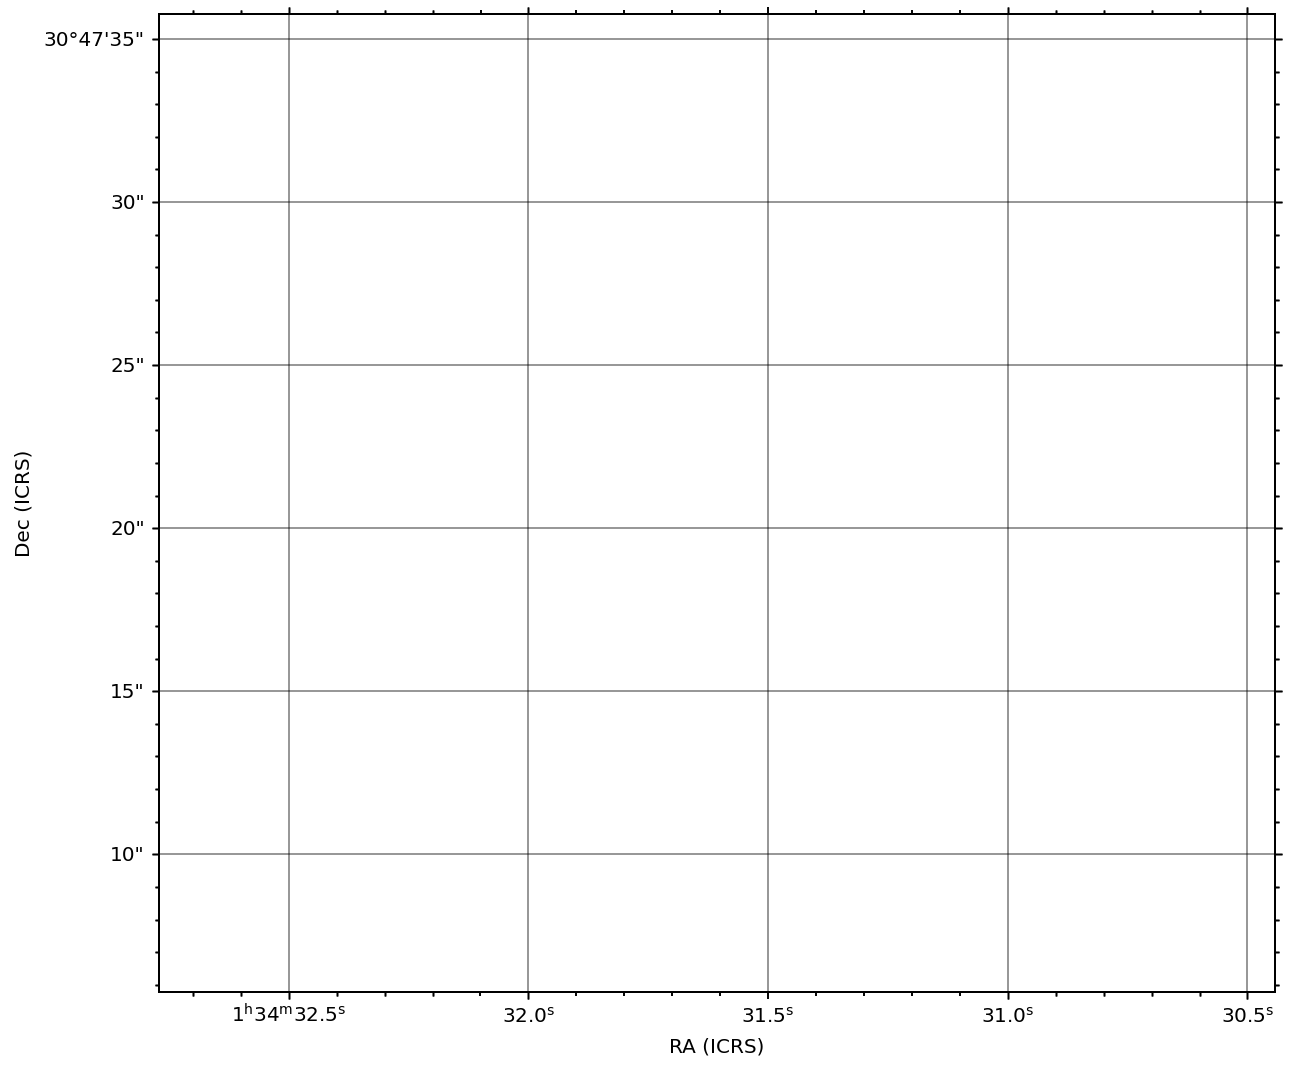

In [2]:
center = [23.6317, 30.7891]
scale = 0.03 * u.arcsec
rad = 0.5 * u.arcmin
npix = int(np.round(rad.to(u.deg)/scale.to(u.deg)).value)
w = WCS(naxis=2)
w.wcs.crval = center
w.wcs.cdelt = np.array([-scale.to(u.deg).value, scale.to(u.deg).value])
w.wcs.crpix = [npix / 2., npix / 2.]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w.pixel_shape = (npix, npix)

fig = aplpy.FITSFigure(w)
fig.add_grid()
fig.grid.set_color('black')

In [3]:
def make_cutout(infile, outfile, ext=0, w=w, rad=rad):
    with fits.open(infile, mode='readonly', memmap=False) as f:
        head = f[ext].header
        data = f[ext].data
        if 'q_fl' in infile:
            if f[1].header['BUNIT'] == r'ELECTRONS':
                sc = f[0].header['EXPTIME'] * f[0].header['CCDGAIN']
            elif f[1].header['BUNIT'] == 'ELECTRONS/S':
                sc = f[0].header['CCDGAIN']**2
            data /= sc
        w1 = WCS(head, fobj=f)
    cutout = Cutout2D(data, position=SkyCoord([w.wcs.crval], unit='deg'),
                      size=rad, wcs=w1, mode='partial')
    f = fits.PrimaryHDU(header=cutout.wcs.to_header(), data=cutout.data)
    f.writeto(outfile, overwrite=True)

make_cutout('../realign/idb601rdq_flt.fits', 'F160W_flt_cutout.fits', ext=1)
make_cutout('../realign/jdb604soq_flc.fits', 'F814W_flc_cutout.fits', ext=4)
make_cutout('../F160W_mosaic.fits', 'F160W_drz_cutout.fits', rad=0.3*u.arcmin)
make_cutout('../F814W_mosaic.fits', 'F814W_drc_cutout.fits', rad=0.2*u.arcmin)